In [1]:
# Install the necessary dependencies

import os
import sys

!{sys.executable} -m pip install --quiet seaborn pandas scikit-learn numpy matplotlib jupyterlab_myst ipython

---
license:
    code: MIT
    content: CC-BY-4.0
github: https://github.com/ocademy-ai/machine-learning
venue: By Ocademy
open_access: true
bibliography:
  - https://raw.githubusercontent.com/ocademy-ai/machine-learning/main/open-machine-learning-jupyter-book/references.bib
---

#  Image segmentation

## What is Image segmentation?

In an image segmentation task (specifically semantic segmentation), the network assigns a label (or class) to each input image. However, suppose you want to know the shape of that object, which pixel belongs to which object, etc. In this case, you need to assign a class to each pixel of the image—this task is known as segmentation. A segmentation model returns much more detailed information about the image. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging, just to name a few.

In [2]:
from IPython.display import HTML
display(HTML("""
<p style="text-align: center;">
<iframe src="https://static-1300131294.cos.ap-shanghai.myqcloud.com/html/image-segmentation/index.html" width="105%" height="700px;" style="border:none;"></iframe>
A demo of image segmentation 1. <a href="https://generic-github-user.github.io/Image-Convolution-Playground/src/">[source]</a>
</p>
"""))

In [3]:
from IPython.display import HTML
display(HTML("""
<p style="text-align: center;">
<iframe src="https://static-1300131294.cos.ap-shanghai.myqcloud.com/html/image-segmentation-2/index.html" width="105%" height="700px;" style="border:none;"></iframe>
A demo of image segmentation 2. <a href="https://github.com/selvam85/deeplab">[source]</a>
</p>
"""))

## How to train a model for image segmentation?

This tutorial uses the Oxford-IIIT Pet Dataset. The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the training and test splits). Each image includes the corresponding labels, and pixel-wise masks. The masks are class-labels for each pixel. Each pixel is given one of three categories:

- Class 1: Pixel belonging to the pet.
- Class 2: Pixel bordering the pet.
- Class 3: None of the above/a surrounding pixel.

And it can be downloaded from [The Oxford-IIIT Pet Dataset](https://academictorrents.com/details/b18bbd9ba03d50b0f7f479acc9f4228a408cecc1).

In [5]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Prepare the Oxford-IIIT Pets dataset

In [6]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In addition, the image color values are normalized to the range [0, 1]. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [7]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask
  
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

The dataset already contains the required training and test splits, so continue to use the same splits:

In [8]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

The following class performs a simple augmentation by randomly-flipping an image. Go to the Image augmentation tutorial to learn more.

In [9]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

Build the input pipeline, applying the augmentation after batching the inputs:

In [11]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)
warnings.filterwarnings('ignore')

Visualize an image example and its corresponding mask from the dataset:

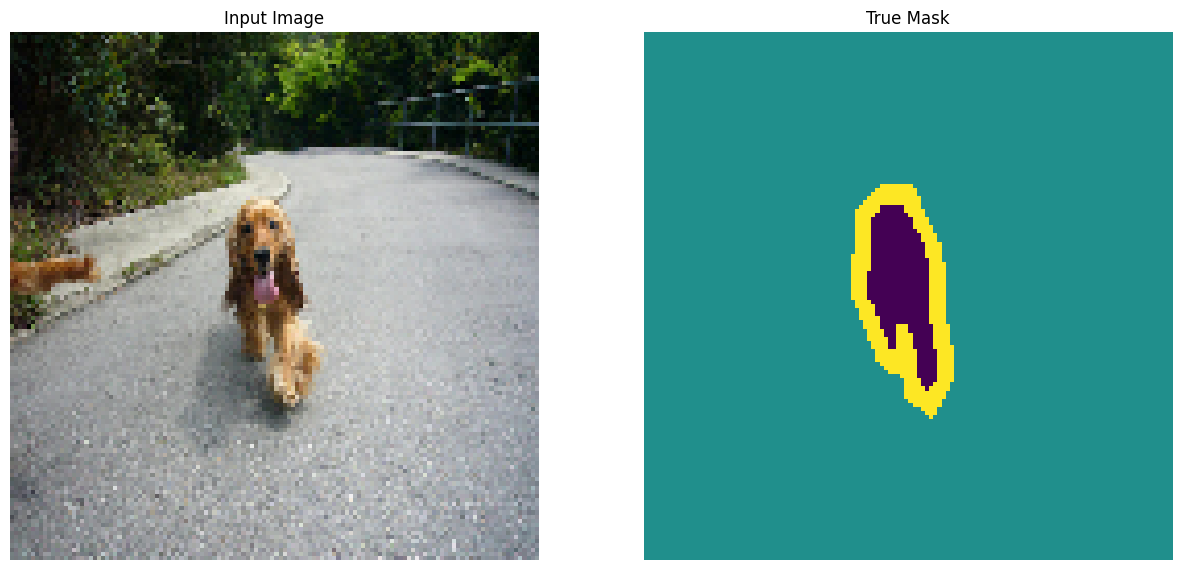

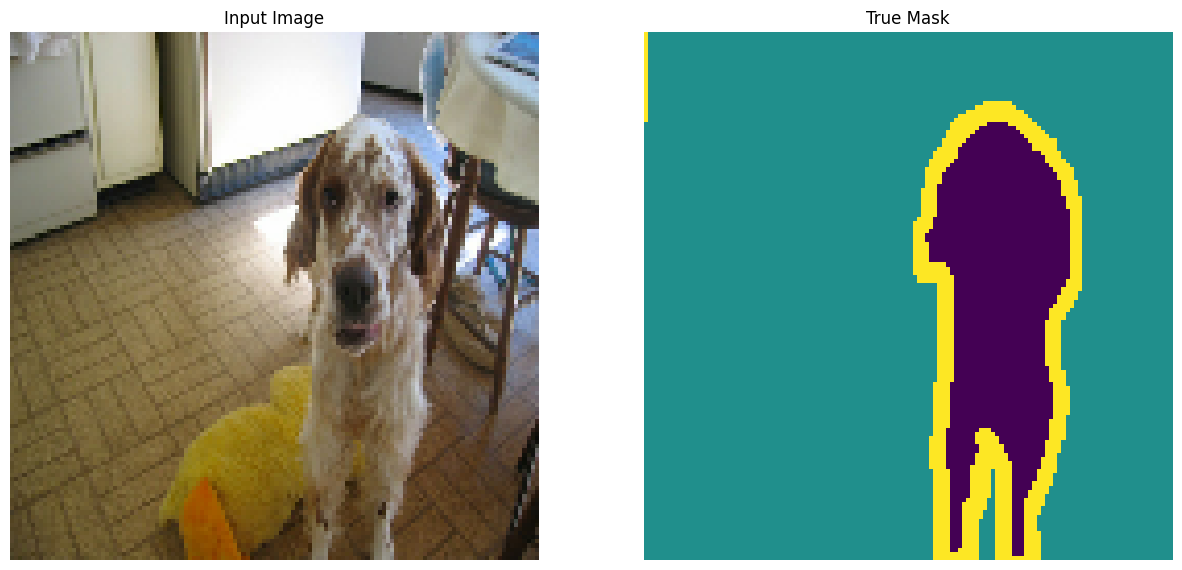

In [12]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()
  
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

:::{figure} https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/imgseg/01_display_dataset.png
---
name: '01_dataset_example_mask' 
width: 90%
---
An example from the dataset
:::

### Define the model

The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). To learn robust features and reduce the number of trainable parameters, use a pretrained model—MobileNetV2—as the encoder. For the decoder, you will use the upsample block, which is already implemented in the pix2pix example in the TensorFlow Examples repo.

:::{note}
The link for paper is https://arxiv.org/pdf/1505.04597.pdf.
:::

As mentioned, the encoder is a pretrained MobileNetV2 model. You will use the model from tf.keras.applications. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

warnings.filterwarnings('ignore')

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples:

In [15]:
from tensorflow.keras import layers

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3)   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Note that the number of filters on the last layer is set to the number of it. This will be one output channel per class.output_channels.

### Train the model

Now, all that is left to do is to compile and train the model. Since this is a multiclass classification problem, use the 'tf.keras.losses.CategoricalCrossentropy' loss function with the argument set to , since the labels are scalar integers instead of vectors of scores for each pixel of every class.from_logitsTrue. When running inference, the label assigned to the pixel is the channel with the highest value. This is what the function is doing.create_mask.

In [18]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

warnings.filterwarnings('ignore')

Try out the model to check what it predicts before training:

In [19]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

Perhaps now we can try to show the predictions.

In [25]:
for images, masks in train_batches.take(1):
  sample_image, sample_mask = images[0], masks[0]
show_predictions()

1/1 [==============================] - 0s 51ms/step


[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
 array([[[0.11404718, 0.13299297, 0.06537655],
         [0.10460062, 0.11903076, 0.06525736],
         [0.08964461, 0.11171325, 0.0555621 ],
         ...,
         [0.0688029 , 0.1292794 , 0.03267463],
         [0.06164216, 0.13725491, 0.03026961],
         [0.10509942, 0.17176609, 0.0447134 ]],
 
        [[0.11912291, 0.13436471, 0.06040135],
         [0.10782758, 0.11567072, 0.06227022],
         [0.08925183, 0.10601041, 0.05068934],
         ...,
         [0.05174632, 0.11988789, 0.02060786],
         [0.04015012, 0.10651042, 0.02277928],
         [0.06948027, 0.12280441, 0.03265429]],
 
        [[0.09274592, 0.12934355, 0.05409845],
         [0.10449817, 0.11234131, 0.05743935],
         [0.08157576, 0.10613463, 0.04915341],
         ...,
         [0.02356819, 0.05816076, 0.00605086],
         [0.03669362, 0.09913234, 0.02744117],
         [0.0348944 , 0.08588317, 0.01743954]],
 
        ...,
 
        [[0.21351941, 0.08421487

1/1 [==============================] - 0s 77ms/step


[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
 array([[[0.11404718, 0.13299297, 0.06537655],
         [0.10460062, 0.11903076, 0.06525736],
         [0.08964461, 0.11171325, 0.0555621 ],
         ...,
         [0.0688029 , 0.1292794 , 0.03267463],
         [0.06164216, 0.13725491, 0.03026961],
         [0.10509942, 0.17176609, 0.0447134 ]],
 
        [[0.11912291, 0.13436471, 0.06040135],
         [0.10782758, 0.11567072, 0.06227022],
         [0.08925183, 0.10601041, 0.05068934],
         ...,
         [0.05174632, 0.11988789, 0.02060786],
         [0.04015012, 0.10651042, 0.02277928],
         [0.06948027, 0.12280441, 0.03265429]],
 
        [[0.09274592, 0.12934355, 0.05409845],
         [0.10449817, 0.11234131, 0.05743935],
         [0.08157576, 0.10613463, 0.04915341],
         ...,
         [0.02356819, 0.05816076, 0.00605086],
         [0.03669362, 0.09913234, 0.02744117],
         [0.0348944 , 0.08588317, 0.01743954]],
 
        ...,
 
        [[0.21351941, 0.08421487


Sample Prediction after epoch 20

57/57 [==============================] - 55s 976ms/step - loss: 0.0978 - accuracy: 0.9591 - val_loss: 0.3668 - val_accuracy: 0.8986


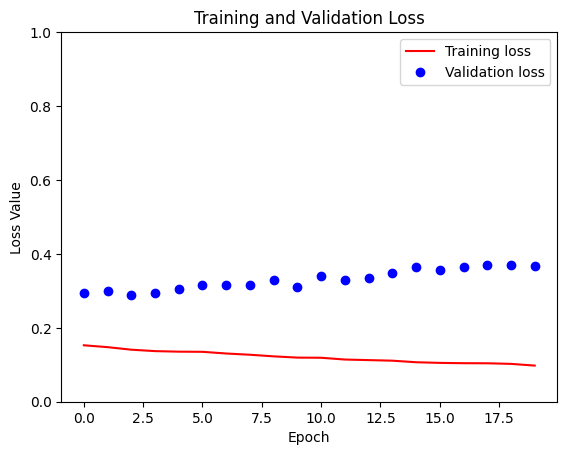

In [26]:
from IPython.display import display, HTML
display(HTML("<style>.output_scroll { height: 300px; }</style>"))

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
    
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()], verbose=1)
                          
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
warnings.filterwarnings('ignore')

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Make predictions

Now, let's make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

show_predictions(test_batches, 3)

:::{figure} https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/imgseg/02_show_prediction.png
---
name: '02_display_prediction' 
width: 90%
---
An example of the output prediction
:::

## History & classic models

In the previous part, we learn the U-Net model. Besides, there are still many excellent models, we will introduce them is this part.

### Code for assisting

In [27]:
import tensorflow as tf

layers = tf.keras.layers
backend = tf.keras.backend


class ResNet(object):
    def __init__(self, version='ResNet50', dilation=None, **kwargs):
        """
       The implementation of ResNet based on Tensorflow.
       :param version: 'ResNet50', 'ResNet101' or 'ResNet152'
       :param dilation: Whether to use dilation strategy
       :param kwargs: other parameters.
       """
        super(ResNet, self).__init__(**kwargs)
        params = {'ResNet50': [2, 3, 5, 2],
                  'ResNet101': [2, 3, 22, 2],
                  'ResNet152': [2, 7, 35, 2]}
        self.version = version
        assert version in params
        self.params = params[version]

        if dilation is None:
            self.dilation = [1, 1]
        else:
            self.dilation = dilation
        assert len(self.dilation) == 2

    def _identity_block(self, input_tensor, kernel_size, filters, stage, block, dilation=1):
        """The identity block is the block that has no conv layer at shortcut.
        # Arguments
            input_tensor: input tensor
            kernel_size: default 3, the kernel size of
                middle conv layer at main path
            filters: list of integers, the filters of 3 conv layer at main path
            stage: integer, current stage label, used for generating layer names
            block: 'a','b'..., current block label, used for generating layer names
        # Returns
            Output tensor for the block.
        """
        filters1, filters2, filters3 = filters
        if backend.image_data_format() == 'channels_last':
            bn_axis = 3
        else:
            bn_axis = 1

        if block > 'z':
            block = chr(ord(block) - ord('z') + ord('A') - 1)

        conv_name_base = 'res' + str(stage) + block + '_branch'
        bn_name_base = 'bn' + str(stage) + block + '_branch'

        x = layers.Conv2D(filters1, (1, 1),
                          kernel_initializer='he_normal',
                          name=conv_name_base + '2a')(input_tensor)
        x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters2, kernel_size,
                          padding='same',
                          kernel_initializer='he_normal',
                          name=conv_name_base + '2b',
                          dilation_rate=dilation)(x)
        x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters3, (1, 1),
                          kernel_initializer='he_normal',
                          name=conv_name_base + '2c')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

        x = layers.add([x, input_tensor])
        x = layers.Activation('relu')(x)
        return x

    def _conv_block(self,
                    input_tensor,
                    kernel_size,
                    filters,
                    stage,
                    block,
                    strides=(2, 2),
                    dilation=1):
        """A block that has a conv layer at shortcut.
        # Arguments
            input_tensor: input tensor
            kernel_size: default 3, the kernel size of
                middle conv layer at main path
            filters: list of integers, the filters of 3 conv layer at main path
            stage: integer, current stage label, used for generating layer names
            block: 'a','b'..., current block label, used for generating layer names
            strides: Strides for the first conv layer in the block.
        # Returns
            Output tensor for the block.
        Note that from stage 3,
        the first conv layer at main path is with strides=(2, 2)
        And the shortcut should have strides=(2, 2) as well
        """
        filters1, filters2, filters3 = filters
        if backend.image_data_format() == 'channels_last':
            bn_axis = 3
        else:
            bn_axis = 1
        conv_name_base = 'res' + str(stage) + block + '_branch'
        bn_name_base = 'bn' + str(stage) + block + '_branch'

        strides = (1, 1) if dilation > 1 else strides

        x = layers.Conv2D(filters1, (1, 1), strides=strides,
                          kernel_initializer='he_normal',
                          name=conv_name_base + '2a')(input_tensor)
        x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters2, kernel_size, padding='same',
                          kernel_initializer='he_normal',
                          name=conv_name_base + '2b',
                          dilation_rate=dilation)(x)
        x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters3, (1, 1),
                          kernel_initializer='he_normal',
                          name=conv_name_base + '2c')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

        shortcut = layers.Conv2D(filters3, (1, 1), strides=strides,
                                 kernel_initializer='he_normal',
                                 name=conv_name_base + '1')(input_tensor)
        shortcut = layers.BatchNormalization(
            axis=bn_axis, name=bn_name_base + '1')(shortcut)

        x = layers.add([x, shortcut])
        x = layers.Activation('relu')(x)
        return x

    def __call__(self, inputs, output_stages='c5', **kwargs):
        """
        call for ResNet50, ResNet101 or ResNet152.
        :param inputs: a 4-D tensor.
        :param output_stages: str or a list of str containing the output stages.
        :param kwargs: other parameters.
        :return: the output of different stages.
        """
        if backend.image_data_format() == 'channels_last':
            bn_axis = 3
        else:
            bn_axis = 1

        dilation = self.dilation

        x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(inputs)
        x = layers.Conv2D(64, (7, 7),
                          strides=(2, 2),
                          padding='valid',
                          kernel_initializer='he_normal',
                          name='conv1')(x)
        x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
        x = layers.Activation('relu')(x)
        x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
        x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
        c1 = x

        x = self._conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
        for i in range(self.params[0]):
            x = self._identity_block(x, 3, [64, 64, 256], stage=2, block=chr(ord('b') + i))
        c2 = x

        x = self._conv_block(x, 3, [128, 128, 512], stage=3, block='a')
        for i in range(self.params[1]):
            x = self._identity_block(x, 3, [128, 128, 512], stage=3, block=chr(ord('b') + i))
        c3 = x

        x = self._conv_block(x, 3, [256, 256, 1024], stage=4, block='a', dilation=dilation[0])
        for i in range(self.params[2]):
            x = self._identity_block(x, 3, [256, 256, 1024], stage=4, block=chr(ord('b') + i), dilation=dilation[0])
        c4 = x

        x = self._conv_block(x, 3, [512, 512, 2048], stage=5, block='a', dilation=dilation[1])
        for i in range(self.params[3]):
            x = self._identity_block(x, 3, [512, 512, 2048], stage=5, block=chr(ord('b') + i), dilation=dilation[1])
        c5 = x

        self.outputs = {'c1': c1,
                        'c2': c2,
                        'c3': c3,
                        'c4': c4,
                        'c5': c5}

        if type(output_stages) is not list:
            return self.outputs[output_stages]
        else:
            return [self.outputs[ci] for ci in output_stages]
            
            
class Network(object):
    def __init__(self, num_classes, version='PAN', base_model='ResNet50', dilation=None, **kwargs):
        super(Network, self).__init__(**kwargs)
        if base_model in ['ResNet50', 'ResNet101', 'ResNet152']:
            self.encoder = ResNet(base_model, dilation=dilation)
        else:
            raise ValueError('The base model {model} is not in the supported model list!!!'.format(model=base_model))

        self.num_classes = num_classes
        self.version = version
        self.base_model = base_model

    def __call__(self, inputs, **kwargs):
        return inputs

    def get_version(self):
        return self.version

    def get_base_model(self):
        return self.base_model

### FCN

:::{note}
The link for paper is https://arxiv.org/pdf/1411.4038v2.pdf.
:::

FCN is the first work to train FCNs end-to-end for pixel-wise prediction and from supervised pre-training. Semantic segmentation faces an inherent tension between semantics and location: global information resolves what while local information resolves where. Deep feature hierarchies jointly encode location and semantics in a localto-global pyramid. FCN defines a novel “skip” architecture to combine deep, coarse, semantic information and shallow, fine, appearance information.

:::{figure} https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/imgseg/03_structure_FCN.png
---
name: '03_display_structure_of_FCN' 
width: 90%
---
[ The structure of FCN ](https://arxiv.org/pdf/1411.4038v2.pdf)
:::

#### Code

In [28]:
import tensorflow as tf

layers = tf.keras.layers
models = tf.keras.models
backend = tf.keras.backend

class FCN(Network):
    def __init__(self, num_classes, version='FCN-8s', base_model='ResNet50', **kwargs):
        """
        The initialization of FCN-8s/16s/32s.
        :param num_classes: the number of predicted classes.
        :param version: 'FCN-8s', 'FCN-16s' or 'FCN-32s'.
        :param base_model: the backbone model
        :param kwargs: other parameters
        """
        fcn = {'FCN-8s': self._fcn_8s,
               'FCN-16s': self._fcn_16s,
               'FCN-32s': self._fcn_32s}
        base_model = 'ResNet50' if base_model is None else base_model

        assert version in fcn
        self.fcn = fcn[version]
        super(FCN, self).__init__(num_classes, version, base_model, **kwargs)

    def __call__(self, inputs=None, input_size=None, **kwargs):
        assert inputs is not None or input_size is not None

        if inputs is None:
            assert isinstance(input_size, tuple)
            inputs = layers.Input(shape=input_size + (3,))
        return self.fcn(inputs)

    def _conv_relu(self, x, filters, kernel_size=1):
        x = layers.Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
        x = layers.ReLU()(x)
        return x

    def _fcn_32s(self, inputs):
        num_classes = self.num_classes

        x = self.encoder(inputs)
        x = self._conv_relu(x, 4096, 7)
        x = layers.Dropout(rate=0.5)(x)
        x = self._conv_relu(x, 4096, 1)
        x = layers.Dropout(rate=0.5)(x)

        x = layers.Conv2D(num_classes, 1, kernel_initializer='he_normal')(x)
        x = layers.Conv2DTranspose(num_classes, 64, strides=32, padding='same', kernel_initializer='he_normal')(x)

        outputs = x
        return models.Model(inputs, outputs, name=self.version)

    def _fcn_16s(self, inputs):
        num_classes = self.num_classes

        if self.base_model in ['DenseNet121',
                               'DenseNet169',
                               'DenseNet201',
                               'DenseNet264',
                               'Xception',
                               'Xception-DeepLab']:
            c4, c5 = self.encoder(inputs, output_stages=['c3', 'c5'])
        else:
            c4, c5 = self.encoder(inputs, output_stages=['c4', 'c5'])

        x = self._conv_relu(c5, 4096, 7)
        x = layers.Dropout(rate=0.5)(x)
        x = self._conv_relu(x, 4096, 1)
        x = layers.Dropout(rate=0.5)(x)

        x = layers.Conv2D(num_classes, 1, kernel_initializer='he_normal')(x)
        x = layers.Conv2DTranspose(num_classes, 4,
                                   strides=2,
                                   padding='same',
                                   kernel_initializer='he_normal')(x)
        c4 = layers.Conv2D(num_classes, 1, kernel_initializer='he_normal')(c4)
        x = layers.Add()([x, c4])

        x = layers.Conv2DTranspose(num_classes, 32,
                                   strides=16,
                                   padding='same',
                                   kernel_initializer='he_normal')(x)

        outputs = x
        return models.Model(inputs, outputs, name=self.version)

    def _fcn_8s(self, inputs):
        num_classes = self.num_classes

        if self.base_model in ['VGG16',
                               'VGG19',
                               'ResNet50',
                               'ResNet101',
                               'ResNet152',
                               'MobileNetV1',
                               'MobileNetV2']:
            c3, c4, c5 = self.encoder(inputs, output_stages=['c3', 'c4', 'c5'])
        else:
            c3, c4, c5 = self.encoder(inputs, output_stages=['c2', 'c3', 'c5'])

        x = self._conv_relu(c5, 4096, 7)
        x = layers.Dropout(rate=0.5)(x)
        x = self._conv_relu(x, 4096, 1)
        x = layers.Dropout(rate=0.5)(x)

        x = layers.Conv2D(num_classes, 1, kernel_initializer='he_normal')(x)
        x = layers.Conv2DTranspose(num_classes, 4,
                                   strides=2,
                                   padding='same',
                                   kernel_initializer='he_normal')(x)
        c4 = layers.Conv2D(num_classes, 1)(c4)
        x = layers.Add()([x, c4])

        x = layers.Conv2DTranspose(num_classes, 4,
                                   strides=2,
                                   padding='same',
                                   kernel_initializer='he_normal')(x)
        c3 = layers.Conv2D(num_classes, 1)(c3)
        x = layers.Add()([x, c3])

        x = layers.Conv2DTranspose(num_classes, 16,
                                   strides=8,
                                   padding='same',
                                   kernel_initializer='he_normal')(x)

        outputs = x
        return models.Model(inputs, outputs, name=self.version)

### SegNet

:::{note}
The link for paper is https://arxiv.org/pdf/1511.00561v3.pdf.
:::

SegNet is a novel and practical deep fully convolutional neural network architecture for semantic pixel-wise segmentation. This core trainable segmentation engine consists of an encoder network, a corresponding decoder network followed by a pixel-wise classification layer. Here is the structure of SegNet:

:::{figure} https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/imgseg/04_structure_SegNet.png
---
name: '04_display_structure_of_SegNet' 
width: 90%
---
[ The structure of SegNet ]https://arxiv.org/pdf/1511.00561v3.pdf )
:::

As we have learnt U-Net, SegNet is similar to it, the main difference is that U-Net does not reuse pooling indices but instead transfers the entire feature map (at the cost of more memory) to the corresponding decoders and concatenates them to upsampled (via deconvolution) decoder feature maps.

#### Code

In [29]:
import tensorflow as tf

layers = tf.keras.layers
models = tf.keras.models
backend = tf.keras.backend


class SegNet(Network):
    def __init__(self, num_classes, version='SegNet', base_model='ResNet50', **kwargs):
        """
        The initialization of SegNet or Bayesian-SegNet.
        :param num_classes: the number of predicted classes.
        :param version: 'SegNet' or 'Bayesian-SegNet'.
        :param base_model: the backbone model
        :param kwargs: other parameters
        """
        base_model = 'ResNet50' if base_model is None else base_model
        assert version in ['SegNet', 'Bayesian-SegNet']
        assert base_model in ['ResNet50',
                              'ResNet101',
                              'ResNet152']
        super(SegNet, self).__init__(num_classes, version, base_model, **kwargs)

    def __call__(self, inputs=None, input_size=None, **kwargs):
        assert inputs is not None or input_size is not None

        if inputs is None:
            assert isinstance(input_size, tuple)
            inputs = layers.Input(shape=input_size + (3,))
        return self._segnet(inputs)

    def _conv_bn_relu(self, x, filters, kernel_size=1, strides=1):
        x = layers.Conv2D(filters, kernel_size,
                          strides=strides,
                          padding='same',
                          kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        return x

    def _segnet(self, inputs):
        num_classes = self.num_classes
        dropout = True if self.version == 'Bayesian-SegNet' else False

        x = self.encoder(inputs)

        if dropout:
            x = layers.Dropout(rate=0.5)(x)
        x = layers.UpSampling2D(size=(2, 2))(x)
        x = self._conv_bn_relu(x, 512, 3, strides=1)
        x = self._conv_bn_relu(x, 512, 3, strides=1)
        x = self._conv_bn_relu(x, 512, 3, strides=1)

        if dropout:
            x = layers.Dropout(rate=0.5)(x)
        x = layers.UpSampling2D(size=(2, 2))(x)
        x = self._conv_bn_relu(x, 512, 3, strides=1)
        x = self._conv_bn_relu(x, 512, 3, strides=1)
        x = self._conv_bn_relu(x, 256, 3, strides=1)

        if dropout:
            x = layers.Dropout(rate=0.5)(x)
        x = layers.UpSampling2D(size=(2, 2))(x)
        x = self._conv_bn_relu(x, 256, 3, strides=1)
        x = self._conv_bn_relu(x, 256, 3, strides=1)
        x = self._conv_bn_relu(x, 128, 3, strides=1)

        if dropout:
            x = layers.Dropout(rate=0.5)(x)
        x = layers.UpSampling2D(size=(2, 2))(x)
        x = self._conv_bn_relu(x, 128, 3, strides=1)
        x = self._conv_bn_relu(x, 64, 3, strides=1)

        if dropout:
            x = layers.Dropout(rate=0.5)(x)
        x = layers.UpSampling2D(size=(2, 2))(x)
        x = self._conv_bn_relu(x, 64, 3, strides=1)
        x = layers.Conv2D(num_classes, 1,
                          strides=1,
                          kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)

        outputs = x
        return models.Model(inputs, outputs, name=self.version)

### DeepLab V3

```{note}
The link for paper is https://arxiv.org/pdf/1706.05587v3.pdf.
```

DeepLab V3 revisits applying dilated convolution, which allows us to effectively enlarge the field of view of filters to incorporate multi-scale context, in the framework of both cascaded modules and spatial pyramid pooling. It consists of dilated convolution with various rates and batch normalization layers. DeepLab experiments with laying out the modules in cascade or in parallel.

:::{figure} https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/imgseg/05_cascade_DeepLab_structure.png
---
name: '05_cascade_dilated_conv_structure' 
width: 90%
---
[ Cascade dilated convolution for DeepLab ] (https://arxiv.org/pdf/1706.05587v3.pdf)
:::

:::{figure} https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/imgseg/06_parallel_DeepLab_structure.png
---
name: '06_parallel_DeepLab_structure' 
width: 90%
---
[ Parallel dilated convolution for DeepLab ] (https://arxiv.org/pdf/1706.05587v3.pdf)
:::

#### Code

In [30]:
from tensorflow.keras.layers import Input,Dropout,BatchNormalization,Activation,Add

In [31]:
import tensorflow as tf

layers = tf.keras.layers
models = tf.keras.models
backend = tf.keras.backend

class DeepLabV3(Network):
    def __init__(self, num_classes, version='DeepLabV3', base_model='ResNet50', **kwargs):
        """
        The initialization of DeepLabV3.
        :param num_classes: the number of predicted classes.
        :param version: 'DeepLabV3'
        :param base_model: the backbone model
        :param kwargs: other parameters
        """
        dilation = [1, 2]
        base_model = 'ResNet50' if base_model is None else base_model

        assert version == 'DeepLabV3'
        assert base_model in ['ResNet50',
                              'ResNet101',
                              'ResNet152']
        super(DeepLabV3, self).__init__(num_classes, version, base_model, dilation, **kwargs)
        self.dilation = dilation

    def __call__(self, inputs=None, input_size=None, **kwargs):
        assert inputs is not None or input_size is not None

        if inputs is None:
            assert isinstance(input_size, tuple)
            inputs = layers.Input(shape=input_size + (3,))
        return self._deeplabv3(inputs)

    def _deeplabv3(self, inputs):
        multi_grid = [1, 2, 4]
        num_classes = self.num_classes
        dilation = self.dilation

        _, h, w, _ = backend.int_shape(inputs)
        self.aspp_size = (h // 16, w // 16)

        x = self.encoder(inputs, output_stages='c4')

        x = self._conv_block(x, 3, [512, 512, 2048], stage=5, block='a', dilation=dilation[1])
        for i in range(2):
            x = self._identity_block(x, 3, [512, 512, 2048],
                                     stage=5,
                                     block=chr(ord('b') + i),
                                     dilation=dilation[1] * multi_grid[i])
        x = self._aspp(x, 256)
        x = layers.Conv2D(num_classes, 1, strides=1, kernel_initializer='he_normal')(x)
        x = layers.UpSampling2D(size=(16, 16), interpolation='bilinear')(x)

        outputs = x
        return models.Model(inputs, outputs, name=self.version)

    def _aspp(self, x, out_filters):
        xs = list()
        x1 = layers.Conv2D(out_filters, 1, strides=1, kernel_initializer='he_normal')(x)
        xs.append(x1)

        for i in range(3):
            xi = layers.Conv2D(out_filters, 3,
                               strides=1,
                               padding='same',
                               dilation_rate=6 * (i + 1))(x)
            xs.append(xi)
        img_pool = layers.GlobalAveragePooling2D()(x)
        img_pool = layers.Conv2D(out_filters, 1, kernel_initializer='he_normal')(img_pool)
        img_pool = layers.UpSampling2D(size=self.aspp_size, interpolation='bilinear')(img_pool)
        xs.append(img_pool)

        x = layers.Concatenate()(xs)
        x = layers.Conv2D(out_filters, 1, strides=1, kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)

        return x

    def _identity_block(self, input_tensor, kernel_size, filters, stage, block, dilation=1):
        """The identity block is the block that has no conv layer at shortcut.
        # Arguments
            input_tensor: input tensor
            kernel_size: default 3, the kernel size of
                middle conv layer at main path
            filters: list of integers, the filters of 3 conv layer at main path
            stage: integer, current stage label, used for generating layer names
            block: 'a','b'..., current block label, used for generating layer names
        # Returns
            Output tensor for the block.
        """
        filters1, filters2, filters3 = filters
        if backend.image_data_format() == 'channels_last':
            bn_axis = 3
        else:
            bn_axis = 1
        conv_name_base = 'res' + str(stage) + block + '_branch'
        bn_name_base = 'bn' + str(stage) + block + '_branch'

        x = layers.Conv2D(filters1, (1, 1),
                          kernel_initializer='he_normal',
                          name=conv_name_base + '2a')(input_tensor)
        x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters2, kernel_size,
                          padding='same',
                          kernel_initializer='he_normal',
                          name=conv_name_base + '2b',
                          dilation_rate=dilation)(x)
        x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters3, (1, 1),
                          kernel_initializer='he_normal',
                          name=conv_name_base + '2c')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

        x = layers.add([x, input_tensor])
        x = layers.Activation('relu')(x)
        return x

    def _conv_block(self,
                    input_tensor,
                    kernel_size,
                    filters,
                    stage,
                    block,
                    strides=(2, 2),
                    dilation=1):
        """A block that has a conv layer at shortcut.
        # Arguments
            input_tensor: input tensor
            kernel_size: default 3, the kernel size of
                middle conv layer at main path
            filters: list of integers, the filters of 3 conv layer at main path
            stage: integer, current stage label, used for generating layer names
            block: 'a','b'..., current block label, used for generating layer names
            strides: Strides for the first conv layer in the block.
        # Returns
            Output tensor for the block.
        Note that from stage 3,
        the first conv layer at main path is with strides=(2, 2)
        And the shortcut should have strides=(2, 2) as well
        """
        filters1, filters2, filters3 = filters
        if backend.image_data_format() == 'channels_last':
            bn_axis = 3
        else:
            bn_axis = 1
        conv_name_base = 'res' + str(stage) + block + '_branch'
        bn_name_base = 'bn' + str(stage) + block + '_branch'

        strides = (1, 1) if dilation > 1 else strides

        x = layers.Conv2D(filters1, (1, 1),
                          strides=strides,
                          name=conv_name_base + '2a',
                          kernel_initializer='he_normal')(input_tensor)
        x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters2, kernel_size,
                          padding='same',
                          name=conv_name_base + '2b',
                          kernel_initializer='he_normal',
                          dilation_rate=dilation)(x)
        x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters3, (1, 1),
                          name=conv_name_base + '2c',
                          kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

        shortcut = layers.Conv2D(filters3, (1, 1),
                                 strides=strides,
                                 name=conv_name_base + '1',
                                 kernel_initializer='he_normal')(input_tensor)
        shortcut = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

        x = layers.add([x, shortcut])
        x = layers.Activation('relu')(x)
        return x

## Your turn! 🚀

TBD.

## Acknowledgments

Thanks to [Yang Lu](https://github.com/luyanger1799) for creating the open-source project [Amazing-Semantic-Segmentation](https://github.com/luyanger1799/Amazing-Semantic-Segmentation), [tensorflow](https://github.com/tensorflow) for creating the open-source course [examples](https://github.com/tensorflow/examples). They inspire the majority of the content in this chapter.